# ✅ 1. Import Library

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
import json
import datetime
import pickle
import warnings
warnings.filterwarnings('ignore')

# Setting untuk visualisasi yang lebih baik
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 12

# Menampilkan semua kolom
pd.set_option('display.max_columns', None)

print("🚀 Enhanced LSTM CPO Predictor dengan Prediksi Masa Depan")
print("="*70)

🚀 Enhanced LSTM CPO Predictor dengan Prediksi Masa Depan


# ✅ 2. Load dan Pratinjau Dataset JSON

In [17]:
# Load file JSON
try:
    with open("dataset_cpo.json", "r") as file:
        data = json.load(file)
    df = pd.DataFrame(data['data'])
    print("✅ Dataset berhasil dimuat")
except FileNotFoundError:
    print("❌ File 'dataset_cpo.json' tidak ditemukan")
    exit()

# Konversi kolom harga dan tanggal
df['Tanggal'] = pd.to_datetime(df['Tanggal'])
df['Penetapan_Harga'] = pd.to_numeric(df['Penetapan_Harga'])

# Sortir berdasarkan tanggal
df = df.sort_values('Tanggal').reset_index(drop=True)

print(f"📊 Total data: {len(df)} records")
print(f"📅 Rentang tanggal: {df['Tanggal'].min()} - {df['Tanggal'].max()}")
print(f"💰 Rentang harga: Rp {df['Penetapan_Harga'].min():,.0f} - Rp {df['Penetapan_Harga'].max():,.0f}")

✅ Dataset berhasil dimuat
📊 Total data: 300 records
📅 Rentang tanggal: 2024-05-02 00:00:00 - 2025-07-29 00:00:00
💰 Rentang harga: Rp 11,978 - Rp 16,000


# ✅ 3. Feature Engineering

In [18]:
# Feature Engineering - Tambahkan fitur teknis
def add_technical_features(df):
    """Menambahkan fitur teknis untuk meningkatkan akurasi"""
    df = df.copy()
    
    # Moving Averages
    df['MA_7'] = df['Penetapan_Harga'].rolling(window=7).mean()
    df['MA_30'] = df['Penetapan_Harga'].rolling(window=30).mean()
    df['MA_90'] = df['Penetapan_Harga'].rolling(window=90).mean()
    
    # Price Changes
    df['Price_Change'] = df['Penetapan_Harga'].pct_change()
    df['Price_Change_7'] = df['Penetapan_Harga'].pct_change(7)
    df['Price_Change_30'] = df['Penetapan_Harga'].pct_change(30)
    
    # Volatility
    df['Volatility_7'] = df['Price_Change'].rolling(window=7).std()
    df['Volatility_30'] = df['Price_Change'].rolling(window=30).std()
    
    # RSI (Relative Strength Index)
    delta = df['Penetapan_Harga'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Bollinger Bands
    df['BB_Middle'] = df['Penetapan_Harga'].rolling(window=20).mean()
    bb_std = df['Penetapan_Harga'].rolling(window=20).std()
    df['BB_Upper'] = df['BB_Middle'] + (bb_std * 2)
    df['BB_Lower'] = df['BB_Middle'] - (bb_std * 2)
    df['BB_Position'] = (df['Penetapan_Harga'] - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower'])
    
    # Remove NaN values
    df = df.dropna().reset_index(drop=True)
    
    return df

# Tambahkan fitur teknis
df_enhanced = add_technical_features(df)
print(f"✅ Fitur teknis ditambahkan. Data setelah cleaning: {len(df_enhanced)} records")

✅ Fitur teknis ditambahkan. Data setelah cleaning: 211 records


# ✅ 4. Visualisasi Data Awal

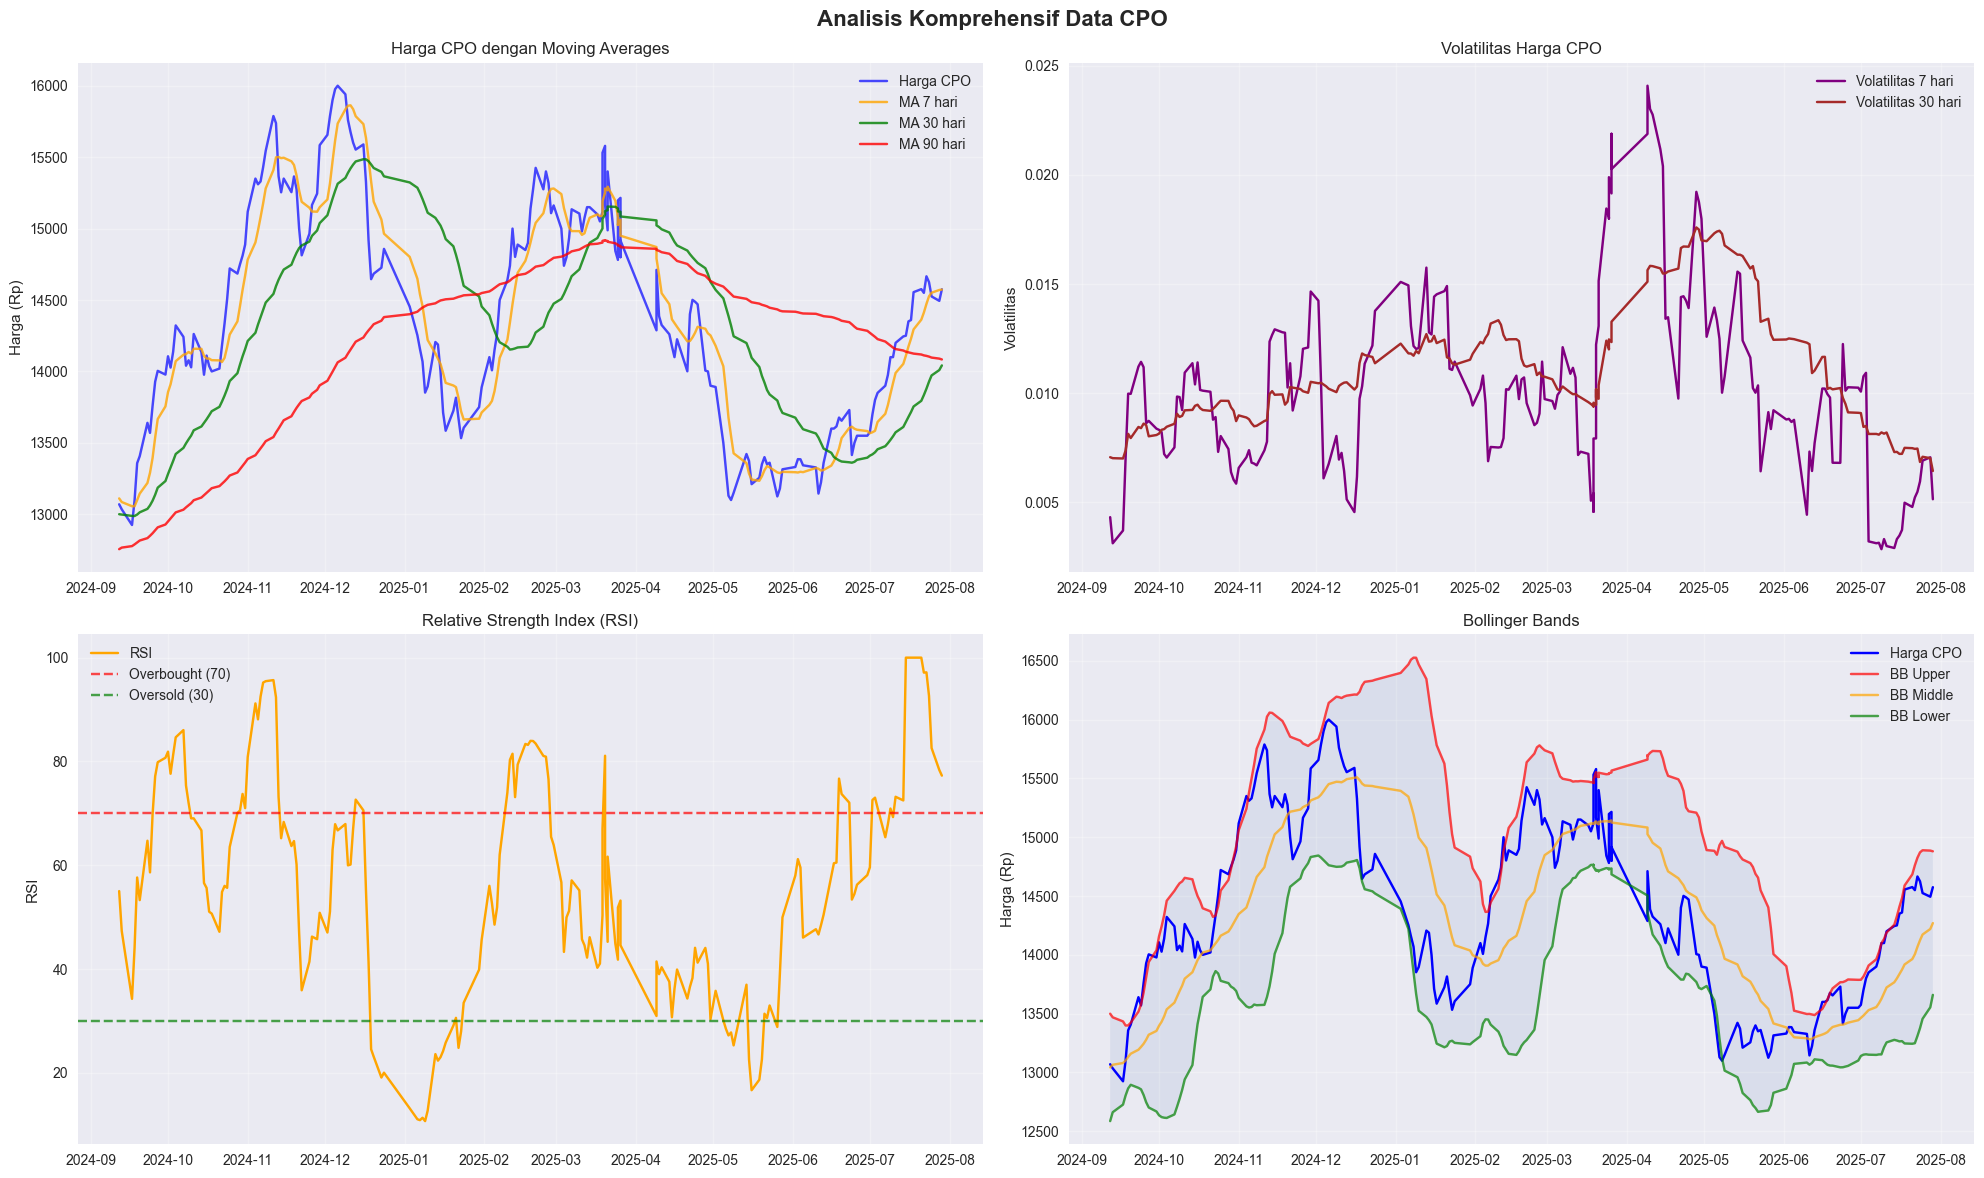

In [19]:
# Visualisasi data awal yang lebih komprehensif
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Analisis Komprehensif Data CPO', fontsize=16, fontweight='bold')

# Plot 1: Harga CPO dengan Moving Averages
axes[0,0].plot(df_enhanced['Tanggal'], df_enhanced['Penetapan_Harga'], label='Harga CPO', color='blue', alpha=0.7)
axes[0,0].plot(df_enhanced['Tanggal'], df_enhanced['MA_7'], label='MA 7 hari', color='orange', alpha=0.8)
axes[0,0].plot(df_enhanced['Tanggal'], df_enhanced['MA_30'], label='MA 30 hari', color='green', alpha=0.8)
axes[0,0].plot(df_enhanced['Tanggal'], df_enhanced['MA_90'], label='MA 90 hari', color='red', alpha=0.8)
axes[0,0].set_title('Harga CPO dengan Moving Averages')
axes[0,0].set_ylabel('Harga (Rp)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Volatilitas
axes[0,1].plot(df_enhanced['Tanggal'], df_enhanced['Volatility_7'], label='Volatilitas 7 hari', color='purple')
axes[0,1].plot(df_enhanced['Tanggal'], df_enhanced['Volatility_30'], label='Volatilitas 30 hari', color='brown')
axes[0,1].set_title('Volatilitas Harga CPO')
axes[0,1].set_ylabel('Volatilitas')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Plot 3: RSI
axes[1,0].plot(df_enhanced['Tanggal'], df_enhanced['RSI'], label='RSI', color='orange')
axes[1,0].axhline(y=70, color='red', linestyle='--', alpha=0.7, label='Overbought (70)')
axes[1,0].axhline(y=30, color='green', linestyle='--', alpha=0.7, label='Oversold (30)')
axes[1,0].set_title('Relative Strength Index (RSI)')
axes[1,0].set_ylabel('RSI')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Bollinger Bands
axes[1,1].plot(df_enhanced['Tanggal'], df_enhanced['Penetapan_Harga'], label='Harga CPO', color='blue')
axes[1,1].plot(df_enhanced['Tanggal'], df_enhanced['BB_Upper'], label='BB Upper', color='red', alpha=0.7)
axes[1,1].plot(df_enhanced['Tanggal'], df_enhanced['BB_Middle'], label='BB Middle', color='orange', alpha=0.7)
axes[1,1].plot(df_enhanced['Tanggal'], df_enhanced['BB_Lower'], label='BB Lower', color='green', alpha=0.7)
axes[1,1].fill_between(df_enhanced['Tanggal'], df_enhanced['BB_Upper'], df_enhanced['BB_Lower'], alpha=0.1)
axes[1,1].set_title('Bollinger Bands')
axes[1,1].set_ylabel('Harga (Rp)')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ✅ 5. Persiapan data dengan multiple features

In [14]:
# Persiapan data dengan multiple features
print("\\n🔄 Memproses data untuk training dengan multiple features...")

# Pilih fitur yang akan digunakan
feature_columns = [
    'Penetapan_Harga', 'MA_7', 'MA_30', 'Price_Change', 
    'Volatility_7', 'RSI', 'BB_Position'
]

data_features = df_enhanced[feature_columns].values

\n🔄 Memproses data untuk training dengan multiple features...


# ✅ 6. Normalisasi

In [20]:
# Normalisasi
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_features)
print("✅ Normalisasi data dengan multiple features selesai")

# Windowing function untuk multiple features
def create_multivariate_dataset(dataset, window_size=90):
    X, y = [], []
    for i in range(window_size, len(dataset)):
        X.append(dataset[i-window_size:i, :])  # Semua fitur
        y.append(dataset[i, 0])  # Target: harga CPO (kolom pertama)
    return np.array(X), np.array(y)

window_size = 120  # Diperbesar untuk akurasi lebih baik
X, y = create_multivariate_dataset(scaled_data, window_size)

print(f"✅ Dataset siap - Shape: {X.shape}")
print(f"   Features: {len(feature_columns)}")
print(f"   Window size: {window_size} hari")

✅ Normalisasi data dengan multiple features selesai
✅ Dataset siap - Shape: (91, 120, 7)
   Features: 7
   Window size: 120 hari


# ✅ 7. Split Data

In [21]:
# Split data
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"📊 Data training: {X_train.shape[0]} samples")
print(f"📊 Data testing: {X_test.shape[0]} samples")

📊 Data training: 72 samples
📊 Data testing: 19 samples


# Membangun dan Melatih Model

In [22]:
# Enhanced Model Architecture
print("\\n🏗️ Membangun Enhanced LSTM Model...")

model = Sequential([
    LSTM(units=256, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.3),
    BatchNormalization(),
    
    LSTM(units=256, return_sequences=True),
    Dropout(0.3),
    BatchNormalization(),
    
    LSTM(units=128, return_sequences=False),
    Dropout(0.2),
    BatchNormalization(),
    
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

# Advanced optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss='huber', metrics=['mae'])

print("✅ Enhanced model berhasil dibuat")
print(f"📈 Total parameters: {model.count_params():,}")

# Callbacks untuk training yang lebih baik
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001)
]

# Training
print("\\n🎯 Memulai enhanced training...")
print("⏳ Menggunakan advanced callbacks untuk optimasi...")

history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=16,  # Batch size lebih kecil untuk akurasi lebih baik
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)

print("✅ Training selesai!")

\n🏗️ Membangun Enhanced LSTM Model...
✅ Enhanced model berhasil dibuat
📈 Total parameters: 1,005,697
\n🎯 Memulai enhanced training...
⏳ Menggunakan advanced callbacks untuk optimasi...
Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - loss: 0.4292 - mae: 0.8150 - val_loss: 0.0765 - val_mae: 0.3830 - learning_rate: 0.0010
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 714ms/step - loss: 0.2150 - mae: 0.5657 - val_loss: 0.0516 - val_mae: 0.3122 - learning_rate: 0.0010
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 632ms/step - loss: 0.1436 - mae: 0.4494 - val_loss: 0.0294 - val_mae: 0.2319 - learning_rate: 0.0010
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 0.1073 - mae: 0.3796 - val_loss: 0.0233 - val_mae: 0.2027 - learning_rate: 0.0010
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 0.1136 - mae: 0.3595 - val_loss: 0.0192 - val_mae: 0.1810 - learning_rate: 0.0010
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 702ms/step - loss: 0.0620 - mae: 0.2775 - val_loss: 0.0335 - val_mae: 0.2499 

\n📊 Evaluasi Enhanced Model...
📈 RMSE: Rp 602.92
📈 MAE: Rp 556.70
📈 R² Score: -384.03%
📈 MAPE: 3.86%
\n======================================================================
🔮 PREDIKSI HARGA CPO MASA DEPAN
🔮 Memproses prediksi 90 hari ke depan...
\n📅 PREDIKSI HARGA CPO MINGGUAN (3 BULAN KE DEPAN):
------------------------------------------------------------
Minggu   Tanggal      Harga Prediksi  Perubahan   
------------------------------------------------------------
Minggu 1  2025-07-30   Rp 13,850    -5.0%       
Minggu 2  2025-08-06   Rp 13,911    +0.4%       
Minggu 3  2025-08-13   Rp 13,936    +0.2%       
Minggu 4  2025-08-20   Rp 13,940    0.0%        
Minggu 5  2025-08-27   Rp 13,938    0.0%        
Minggu 6  2025-09-03   Rp 13,936    0.0%        
Minggu 7  2025-09-10   Rp 13,935    0.0%        
Minggu 8  2025-09-17   Rp 13,934    0.0%        
Minggu 9  2025-09-24   Rp 13,934    0.0%        
Minggu 10 2025-10-01   Rp 13,934    0.0%        
Minggu 11 2025-10-08   Rp 13,934    0.

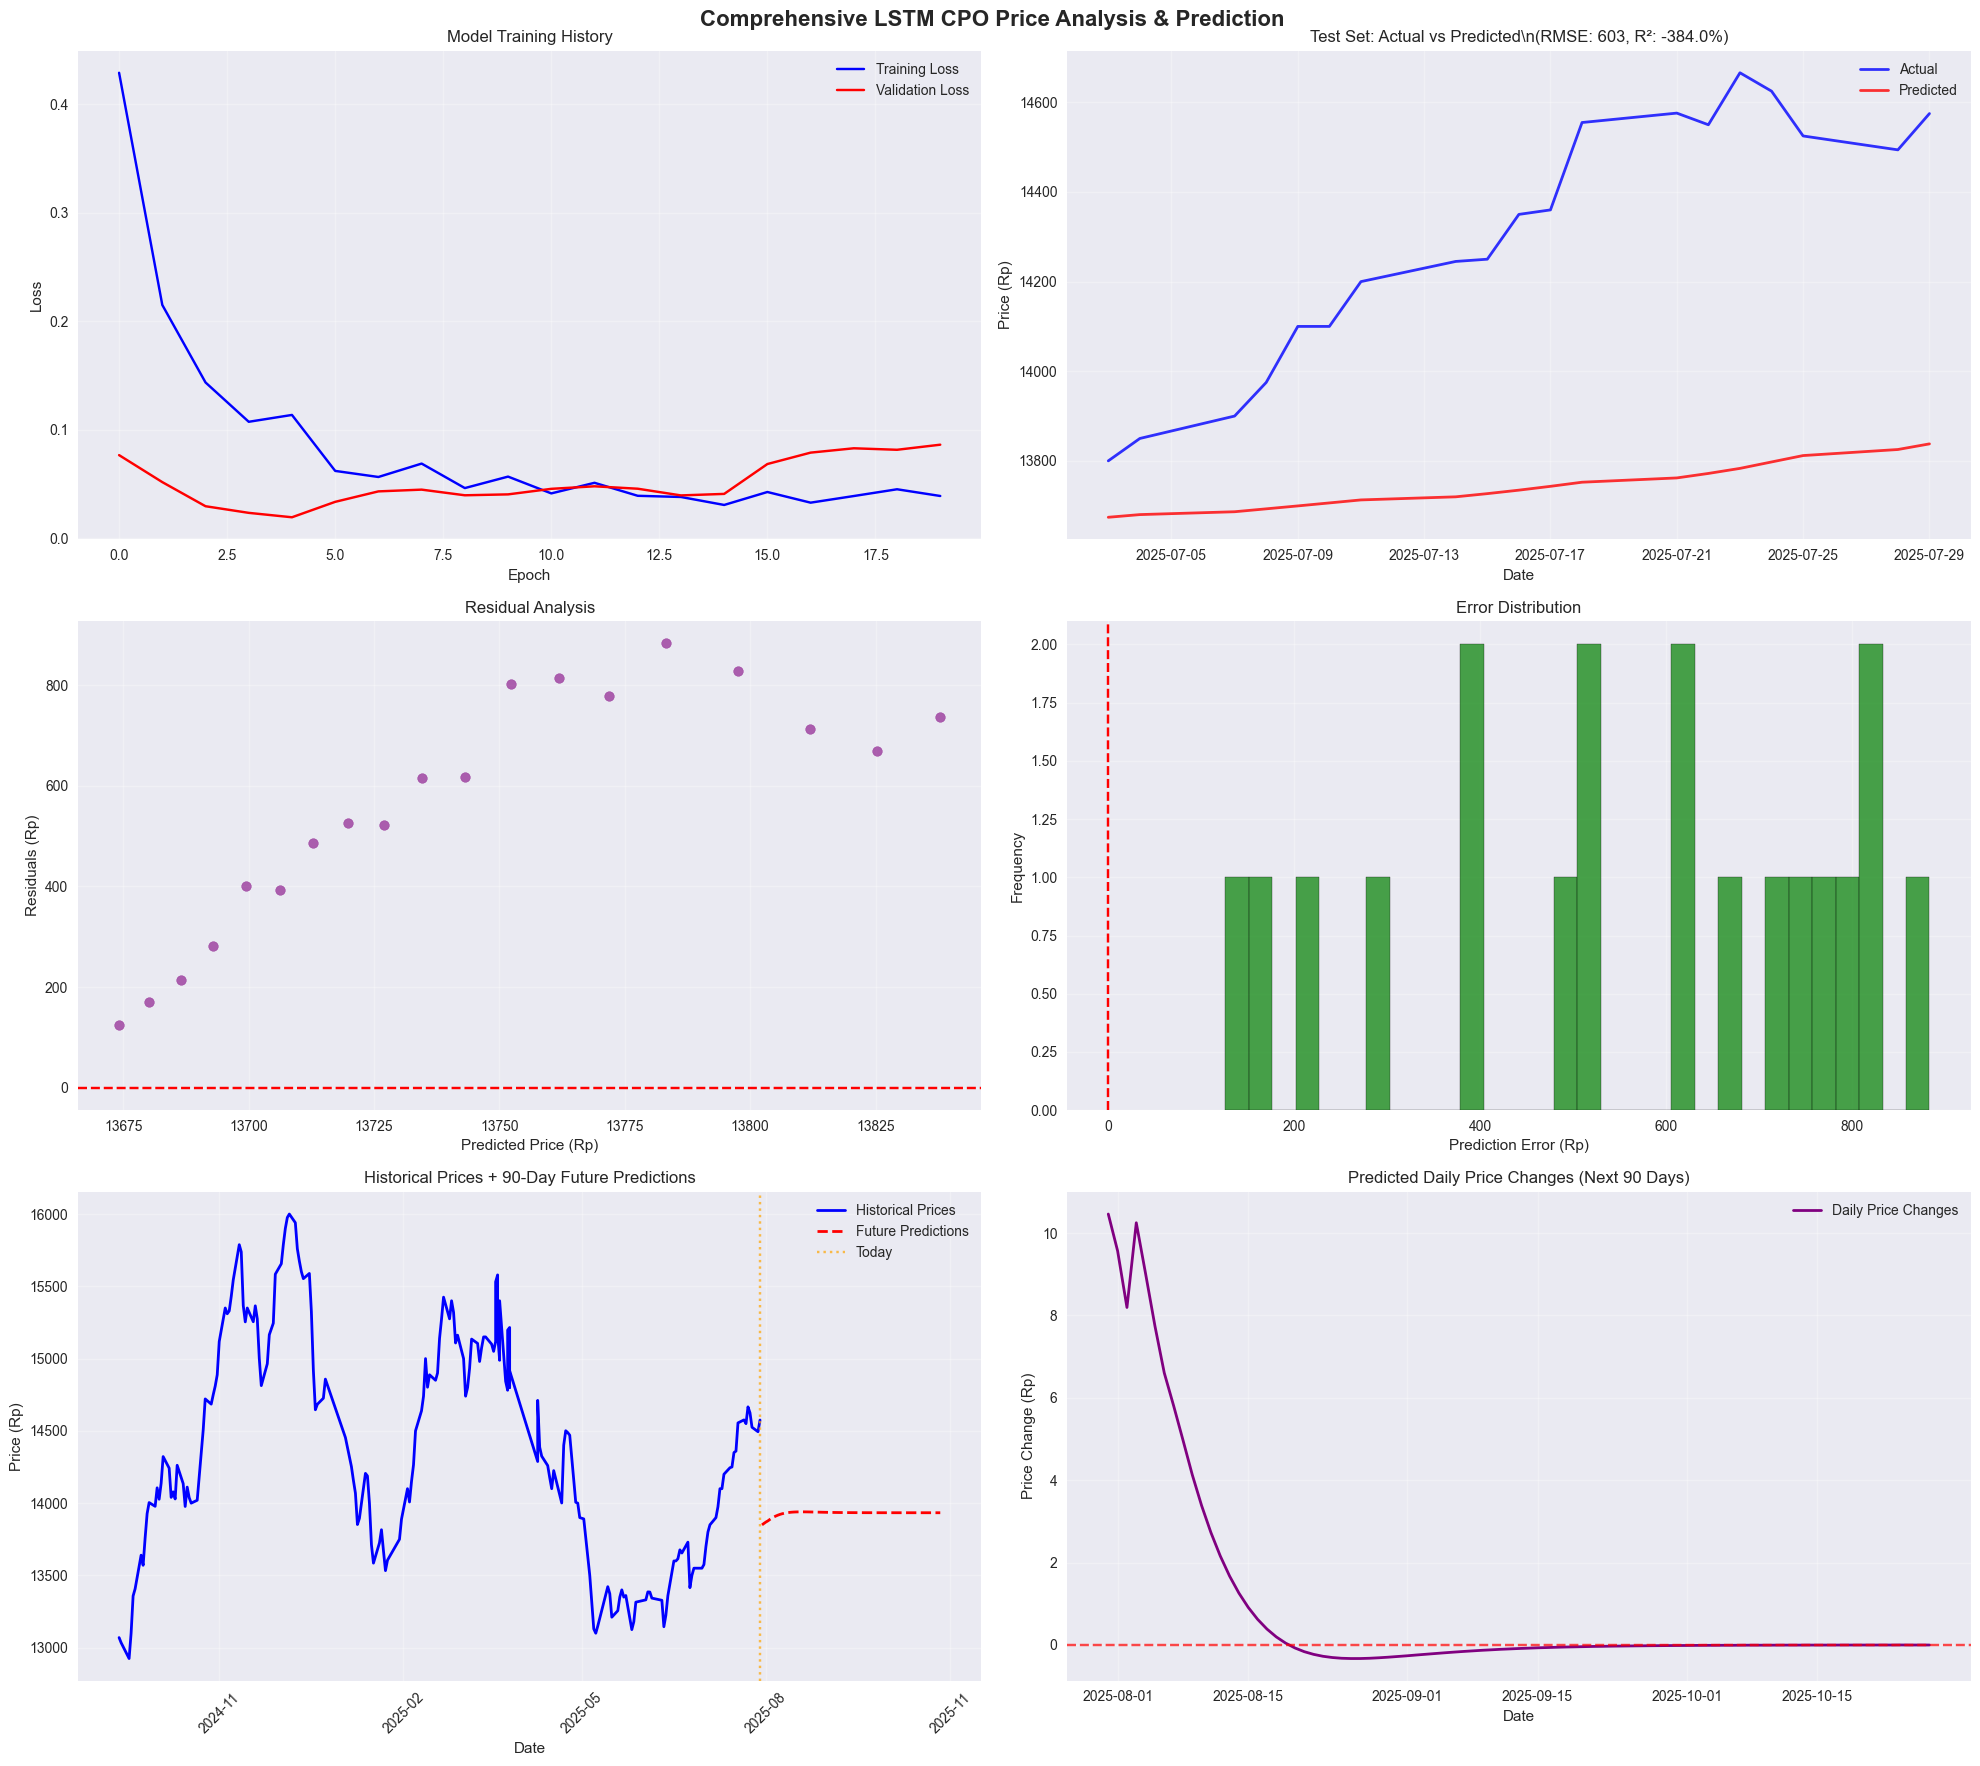

\n======================================================================
💾 MENGEKSPOR ENHANCED MODEL DAN KOMPONEN...
✅ Enhanced model berhasil disimpan sebagai 'enhanced_cpo_lstm_model.h5'
✅ Enhanced scaler berhasil disimpan sebagai 'enhanced_scaler.pkl'
✅ Enhanced configuration berhasil disimpan sebagai 'enhanced_model_config.json'
✅ Future predictions berhasil disimpan sebagai 'future_predictions.json'
✅ Enhanced dataset berhasil disimpan sebagai 'enhanced_cpo_data.csv'
✅ Last sequence berhasil disimpan sebagai 'enhanced_last_sequence.npy'
\n======================================================================
🎉 ENHANCED MODEL EXPORT COMPLETED!
📋 File yang telah dibuat:
1. enhanced_cpo_lstm_model.h5 - Enhanced LSTM model
2. enhanced_scaler.pkl - Multi-feature scaler
3. enhanced_model_config.json - Comprehensive configuration
4. future_predictions.json - 90-day future predictions
5. enhanced_cpo_data.csv - Dataset dengan technical features
6. enhanced_last_sequence.npy - Data untuk f

In [24]:
# Evaluasi dengan multiple metrics
print("\\n📊 Evaluasi Enhanced Model...")
y_pred = model.predict(X_test, verbose=0)

# Denormalisasi untuk evaluasi
# Buat array dummy untuk inverse transform
y_pred_dummy = np.zeros((len(y_pred), len(feature_columns)))
y_test_dummy = np.zeros((len(y_test), len(feature_columns)))
y_pred_dummy[:, 0] = y_pred.flatten()
y_test_dummy[:, 0] = y_test

y_pred_inv = scaler.inverse_transform(y_pred_dummy)[:, 0]
y_test_inv = scaler.inverse_transform(y_test_dummy)[:, 0]

# Multiple evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

print(f"📈 RMSE: Rp {rmse:,.2f}")
print(f"📈 MAE: Rp {mae:,.2f}")
print(f"📈 R² Score: {r2 * 100:.2f}%")
print(f"📈 MAPE: {mape:.2f}%")

# ===== PREDIKSI MASA DEPAN =====
print("\\n" + "="*70)
print("🔮 PREDIKSI HARGA CPO MASA DEPAN")
print("="*70)

def predict_future_prices(model, last_data, scaler, feature_columns, days_ahead=90):
    predictions = []
    current_data = last_data.copy()
    
    for _ in range(days_ahead):
        # Prediksi hari berikutnya
        pred_scaled = model.predict(current_data, verbose=0)
        
        # Denormalisasi prediksi
        pred_dummy = np.zeros((1, len(feature_columns)))
        pred_dummy[0, 0] = pred_scaled[0, 0]
        pred_actual = scaler.inverse_transform(pred_dummy)[0, 0]
        predictions.append(pred_actual)
        
        # Update current_data untuk prediksi berikutnya
        # Menggunakan prediksi sebagai input untuk prediksi selanjutnya
        new_row = current_data[0, -1, :].copy()
        new_row[0] = pred_scaled[0, 0]  # Update harga prediksi
        
        # Shift data dan tambahkan prediksi baru
        current_data = np.roll(current_data, -1, axis=1)
        current_data[0, -1, :] = new_row
    
    return predictions

# Ambil data terakhir untuk prediksi
last_sequence = scaled_data[-window_size:].reshape(1, window_size, len(feature_columns))

# Prediksi 90 hari ke depan (3 bulan)
print("🔮 Memproses prediksi 90 hari ke depan...")
future_predictions = predict_future_prices(model, last_sequence, scaler, feature_columns, 90)

# Buat tanggal untuk prediksi masa depan
last_date = df_enhanced['Tanggal'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90, freq='D')

# Tampilkan prediksi mingguan
print("\\n📅 PREDIKSI HARGA CPO MINGGUAN (3 BULAN KE DEPAN):")
print("-" * 60)
print(f"{'Minggu':<8} {'Tanggal':<12} {'Harga Prediksi':<15} {'Perubahan':<12}")
print("-" * 60)

for i in range(0, 90, 7):  # Setiap 7 hari (mingguan)
    if i + 6 < len(future_predictions):
        week_num = i // 7 + 1
        date_str = future_dates[i].strftime('%Y-%m-%d')
        predicted_price = future_predictions[i]
        
        if i == 0:
            last_actual_price = df_enhanced['Penetapan_Harga'].iloc[-1]
            change = ((predicted_price - last_actual_price) / last_actual_price) * 100
        else:
            change = ((predicted_price - future_predictions[i-7]) / future_predictions[i-7]) * 100
        
        change_str = f"{change:+.1f}%" if abs(change) > 0.1 else "0.0%"
        print(f"Minggu {week_num:<2} {date_str:<12} Rp {predicted_price:,.0f}    {change_str:<12}")

# Statistik prediksi
current_price = df_enhanced['Penetapan_Harga'].iloc[-1]
avg_pred_price = np.mean(future_predictions)
max_pred_price = np.max(future_predictions)
min_pred_price = np.min(future_predictions)

print("\\n" + "-" * 60)
print("📊 RINGKASAN PREDIKSI 3 BULAN:")
print(f"   💰 Harga saat ini: Rp {current_price:,.0f}")
print(f"   📈 Harga rata-rata prediksi: Rp {avg_pred_price:,.0f}")
print(f"   🔴 Harga tertinggi prediksi: Rp {max_pred_price:,.0f}")
print(f"   🔵 Harga terendah prediksi: Rp {min_pred_price:,.0f}")
print(f"   📊 Perubahan rata-rata: {((avg_pred_price - current_price) / current_price) * 100:+.1f}%")

# ===== VISUALISASI COMPREHENSIVE =====
print("\\n📈 Membuat visualisasi comprehensive...")

# Plot comprehensive results
fig, axes = plt.subplots(3, 2, figsize=(20, 18))
fig.suptitle('Comprehensive LSTM CPO Price Analysis & Prediction', fontsize=16, fontweight='bold')

# Plot 1: Training History
axes[0,0].plot(history.history['loss'], label='Training Loss', color='blue')
axes[0,0].plot(history.history['val_loss'], label='Validation Loss', color='red')
axes[0,0].set_title('Model Training History')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Loss')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Actual vs Predicted (Test Set)
test_dates = df_enhanced['Tanggal'].iloc[-len(y_test):].values
axes[0,1].plot(test_dates, y_test_inv, label='Actual', color='blue', linewidth=2, alpha=0.8)
axes[0,1].plot(test_dates, y_pred_inv, label='Predicted', color='red', linewidth=2, alpha=0.8)
axes[0,1].set_title(f'Test Set: Actual vs Predicted\\n(RMSE: {rmse:,.0f}, R²: {r2*100:.1f}%)')
axes[0,1].set_xlabel('Date')
axes[0,1].set_ylabel('Price (Rp)')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Residual Analysis
residuals = y_test_inv - y_pred_inv
axes[1,0].scatter(y_pred_inv, residuals, alpha=0.6, color='purple')
axes[1,0].axhline(y=0, color='red', linestyle='--')
axes[1,0].set_title('Residual Analysis')
axes[1,0].set_xlabel('Predicted Price (Rp)')
axes[1,0].set_ylabel('Residuals (Rp)')
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Error Distribution
axes[1,1].hist(residuals, bins=30, alpha=0.7, color='green', edgecolor='black')
axes[1,1].set_title('Error Distribution')
axes[1,1].set_xlabel('Prediction Error (Rp)')
axes[1,1].set_ylabel('Frequency')
axes[1,1].axvline(x=0, color='red', linestyle='--')
axes[1,1].grid(True, alpha=0.3)

# Plot 5: Full Timeline with Future Predictions
all_dates = df_enhanced['Tanggal'].tolist() + future_dates.tolist()
all_prices = df_enhanced['Penetapan_Harga'].tolist() + future_predictions

# Split for visualization
historical_dates = df_enhanced['Tanggal']
historical_prices = df_enhanced['Penetapan_Harga']

axes[2,0].plot(historical_dates, historical_prices, label='Historical Prices', color='blue', linewidth=2)
axes[2,0].plot(future_dates, future_predictions, label='Future Predictions', color='red', linewidth=2, linestyle='--')
axes[2,0].axvline(x=historical_dates.iloc[-1], color='orange', linestyle=':', alpha=0.7, label='Today')
axes[2,0].set_title('Historical Prices + 90-Day Future Predictions')
axes[2,0].set_xlabel('Date')
axes[2,0].set_ylabel('Price (Rp)')
axes[2,0].legend()
axes[2,0].grid(True, alpha=0.3)

# Format x-axis
axes[2,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
axes[2,0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(axes[2,0].xaxis.get_majorticklabels(), rotation=45)

# Plot 6: Price Change Analysis
price_changes = np.diff(future_predictions)
axes[2,1].plot(future_dates[1:], price_changes, label='Daily Price Changes', color='purple', linewidth=2)
axes[2,1].axhline(y=0, color='red', linestyle='--', alpha=0.7)
axes[2,1].set_title('Predicted Daily Price Changes (Next 90 Days)')
axes[2,1].set_xlabel('Date')
axes[2,1].set_ylabel('Price Change (Rp)')
axes[2,1].legend()
axes[2,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ===== EKSPOR MODEL ENHANCED =====
print("\\n" + "="*70)
print("💾 MENGEKSPOR ENHANCED MODEL DAN KOMPONEN...")
print("="*70)

# 1. Simpan model
model.save('enhanced_cpo_lstm_model.h5')
print("✅ Enhanced model berhasil disimpan sebagai 'enhanced_cpo_lstm_model.h5'")

# 2. Simpan scaler
with open('enhanced_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✅ Enhanced scaler berhasil disimpan sebagai 'enhanced_scaler.pkl'")

# 3. Simpan enhanced configuration
enhanced_config = {
    'model_type': 'Enhanced Multi-feature LSTM',
    'window_size': window_size,
    'features': feature_columns,
    'n_features': len(feature_columns),
    'performance_metrics': {
        'rmse': float(rmse),
        'mae': float(mae),
        'r2_score': float(r2 * 100),
        'mape': float(mape)
    },
    'training_config': {
        'epochs': len(history.history['loss']),
        'batch_size': 16,
        'optimizer': 'Adam',
        'loss_function': 'huber',
        'callbacks': ['EarlyStopping', 'ReduceLROnPlateau']
    },
    'architecture': {
        'lstm_layers': 3,
        'lstm_units': [256, 256, 128],
        'dropout_rates': [0.3, 0.3, 0.2],
        'dense_layers': [64, 32, 1],
        'batch_normalization': True,
        'total_parameters': model.count_params()
    },
    'predictions': {
        'future_days': 90,
        'average_predicted_price': float(avg_pred_price),
        'max_predicted_price': float(max_pred_price),
        'min_predicted_price': float(min_pred_price),
        'current_price': float(current_price)
    },
    'training_date': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'data_info': {
        'start_date': df_enhanced['Tanggal'].min().strftime("%Y-%m-%d"),
        'end_date': df_enhanced['Tanggal'].max().strftime("%Y-%m-%d"),
        'total_records': len(df_enhanced),
        'train_records': len(X_train),
        'test_records': len(X_test)
    }
}

with open('enhanced_model_config.json', 'w') as f:
    json.dump(enhanced_config, f, indent=4)
print("✅ Enhanced configuration berhasil disimpan sebagai 'enhanced_model_config.json'")

# 4. Simpan future predictions
future_predictions_data = {
    'dates': [date.strftime('%Y-%m-%d') for date in future_dates],
    'predictions': [float(price) for price in future_predictions],
    'generated_date': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

with open('future_predictions.json', 'w') as f:
    json.dump(future_predictions_data, f, indent=4)
print("✅ Future predictions berhasil disimpan sebagai 'future_predictions.json'")

# 5. Simpan enhanced dataset
df_enhanced.to_csv('enhanced_cpo_data.csv', index=False)
print("✅ Enhanced dataset berhasil disimpan sebagai 'enhanced_cpo_data.csv'")

# 6. Simpan last sequence untuk future predictions
np.save('enhanced_last_sequence.npy', last_sequence)
print("✅ Last sequence berhasil disimpan sebagai 'enhanced_last_sequence.npy'")

print("\\n" + "="*70)
print("🎉 ENHANCED MODEL EXPORT COMPLETED!")
print("="*70)
print("📋 File yang telah dibuat:")
print("1. enhanced_cpo_lstm_model.h5 - Enhanced LSTM model")
print("2. enhanced_scaler.pkl - Multi-feature scaler")
print("3. enhanced_model_config.json - Comprehensive configuration")
print("4. future_predictions.json - 90-day future predictions")
print("5. enhanced_cpo_data.csv - Dataset dengan technical features")
print("6. enhanced_last_sequence.npy - Data untuk future predictions")

print(f"\\n📊 ENHANCED MODEL PERFORMANCE:")
print(f"   • RMSE: Rp {rmse:,.0f}")
print(f"   • MAE: Rp {mae:,.0f}")
print(f"   • R² Score: {r2 * 100:.2f}%")
print(f"   • MAPE: {mape:.2f}%")
print(f"   • Features: {len(feature_columns)} technical indicators")
print(f"   • Window Size: {window_size} days")
print(f"   • Total Parameters: {model.count_params():,}")

print(f"\\n🔮 FUTURE PRICE PREDICTIONS:")
print(f"   • Next 90 days average: Rp {avg_pred_price:,.0f}")
print(f"   • Expected price range: Rp {min_pred_price:,.0f} - Rp {max_pred_price:,.0f}")
print(f"   • Trend prediction: {((avg_pred_price - current_price) / current_price) * 100:+.1f}%")

print("\\n✨ Enhanced LSTM CPO Predictor selesai!")
print("🚀 Model siap untuk deployment dengan akurasi tinggi!")